# 3i005 - projet 2 - 2020fev
# CLASSIFICATIONS PROBABILISTES

Le but de ce projet est d'étudier les méthodes de classifications auxquelles les statistiques donnent accès naturellement. Il s'agira donc d'étudier les outils de classifications probabilistes. C'est bien évidemment une petite partie de l'ensemble des méthodes de classification existant.

### Evaluation du projet
L'ensemble des codes que vous réaliserez seront accessible à partir du ficher `projet.py`.  L'évaluation de votre code se fera à l'aide de données autres que celles du projet dans un programme qui commencera par importer votre `projet.py`. **il faudra donc une vigilance particulière à respecter les noms et la signature des classes, fonctions et méthodes ! Le code dans ce notebook ne doit pas être modifié, votre code dans `projet.py` doit permettre d'exécuter ce notebook et d'avoir les mêmes résultats que ceux de la version originale**.

* Si des questions méritent des réponses ouvertes, ces réponses seront insérées dans ce notebook dans une cellule immédiatement en dessous de celle contenant la question (visible par <img src="question.png"  align="bottom">) et nulle part ailleurs (la cellule existe et contient le texte `(votre réponse ici)`).

* Une attention soutenue sera demandée à la documentation de votre code et à sa qualité ainsi qu'à la qualité des réponses ouvertes dans ce notebook.

* Enfin, tous nos classifieurs seront codés dans des classes, sous-classes de `AbstractClassifier` dans le fichier `utils.py`. Pour rappel de la programmation orientée object en python 3, par exemple : https://realpython.com/python3-object-oriented-programming/#dog-park-example. 

* Vous soumettrez un fichier `projet2-GrX-Y.{zip|tgz}` où `X` est votre groupe, `Y` est votre (ou vos) noms. Le format `zip` ou `tgz` est au choix.

### Base utilisée : heart disease (Cleveland database)

        This database contains 76 attributes, but all published experiments refer to using a subset of 14 of them. In particular, the Cleveland database is the only one that has been used by ML researchers to this date. 
        The `target` field refers to the presence of heart disease in the patient. It is integer valued from 0 (no presence) to 4. Experiments with the Cleveland database have concentrated on simply attempting to distinguish presence (values 1) from absence (value 0). 

| champs | definition |
|--------|------------|
|age|  age in years| 
|sex| (1 = male; 0 = female)| 
|cp|  chest pain type| 
|trestbps| resting blood pressure (in mm Hg on admission to the hospital)| 
|chol| serum cholestoral in mg/dl| 
|fbs| (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)| 
|restecg| resting electrocardiographic results| 
|thalach| maximum heart rate achieved| 
|exang| exercise induced angina (1 = yes; 0 = no)| 
|oldpeak| ST depression induced by exercise relative to rest| 
|slope|the slope of the peak exercise ST segment| 
|ca| number of major vessels (0-3) colored by flourosopy| 
|thal|3 = normal; 6 = fixed defect; 7 = reversable defect| 
|target| 1 or 0 | 

Notre but est donc de proposer des classifieurs qui tentent de prédire la valeur de `target` à partir des autres champs en utilisant des arguments probabilistes.

## Simplification de la base (prélude au projet : pas de travail à faire dans cette partie)

In [1]:
import pandas as pd # package for high-performance, easy-to-use data structures and data analysis
import numpy as np # fundamental package for scientific computing with Python

In [2]:
# to allow autoreload of projet.py
%load_ext autoreload
%autoreload 2

import utils
import projet # votre code

In [3]:
data=pd.read_csv("heart.csv")
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


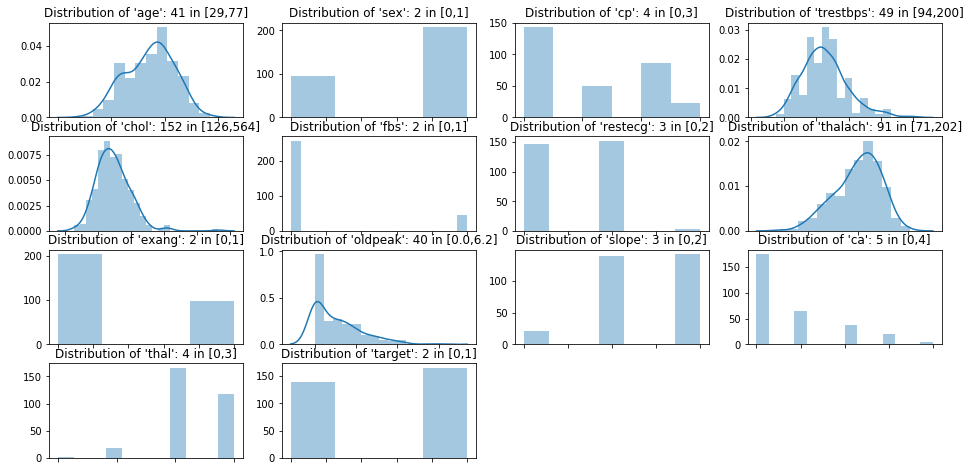

In [4]:
utils.viewData(data)

Certaines variabless comme `age`, `thalach`, etc. possèdent un grand nombre de modalités, rendant difficile le traitement. Nous simplifions donc la base en discrétisant au mieux toutes les variables qui ont plus de 5 valeurs.

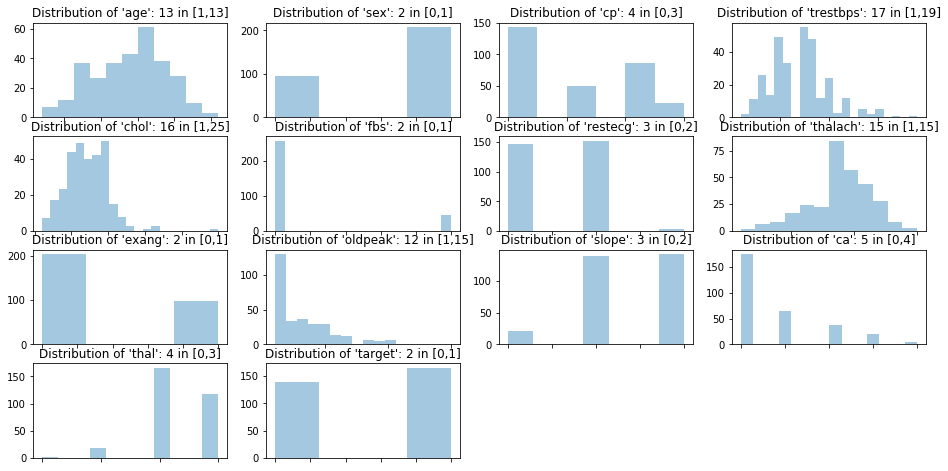

In [5]:
discretise=utils.discretizeData(data)
utils.viewData(discretise,kde=False)

Nous utilisons maintenant 2 fichiers csv **préparés à l'avance pour ce projet** à partir de cette base afin de rendre les résultats plus intéressants (en particulier, les 2 classes sont un peu plus déséquilibrées).

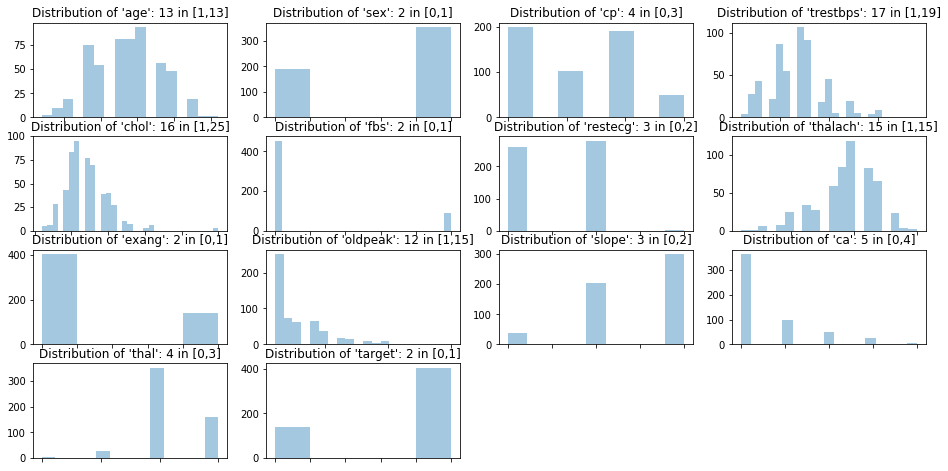

In [6]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
utils.viewData(train,kde=False)

<img src="warning.png"  align="middle"> À partir de maintenant, nous utilisons le dataframe `train` qui contient les données pour l'apprentissage et `test` qui contient les données pour la validation.

# Classification a priori

## Question 1 
Dans une fonction `getPrior`, calculer la probabilité a priori de la classe $1$ ainsi que l'intervalle de confiance à 95% pour l'estimation de cette probabilité.

In [7]:
train['target'].describe()

count    542.000000
mean       0.745387
std        0.436046
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: target, dtype: float64

In [8]:
# cette fonction doit donc rendre un dictionnaire contenant 3 clés 'estimation', 'min5pourcent', 'max5pourcent' (L'ORDRE DES CLES N'EST PAS IMPORTANTE DANS UN DICTIONNAIRE)
projet.getPrior(train)

{'estimation': 0.7453874538745388,
 'min5pourcent': 0.7086771163094081,
 'max5pourcent': 0.7820977914396694}

In [9]:
projet.getPrior(test) 

{'estimation': 0.69,
 'min5pourcent': 0.6257408575614747,
 'max5pourcent': 0.7542591424385252}

## Question 2 : programmation orientée objet dans la hiérarchie des `Classifier`

On propose de représenter les classifieurs en python par des classes d'une hiérarchie. Un classifieur répond à une question principale : étant donné un vecteur d'attributs, quelle est la classe proposée ?
Nous proposons donc une classe de base qu'il s'agira d'**améliorer et de spécialiser en la sous-classant** : `AbstractClassifier` dans le fichier `utils.py` 

### Question 2a
Ecrire dans `projet.py` un classifieur `APrioriClassifier` (enfant de `AbstractClassifier`) qui utilise le résultat de la question 1 pour estimer très simplement la classe de chaque individu par la classe majoritaire.  

In [10]:
cl=projet.APrioriClassifier()
clpredite=cl.estimClass(None) # n'importe quoi donne la même classe pour un classifieur a priori 
# la valeur prédite n'est pas affichée sciemment

<div style="float:right;margin:0 10px 10px 0">
    <img src="PrecisionRappel.png">
</div>

### Question 2b : évaluation de classifieurs

Implémenter également la méthode `statsOnDF` qui rendra les valeurs suivantes :

- VP : nombre d'individus avec target=1 et classe prévue=1
- VN : nombre d'individus avec target=0 et classe prévue=0
- FP : nombre d'individus avec target=0 et classe prévue=1
- FN : nombre d'individus avec target=1 et classe prévue=0
- précision 
- rappel


- <i>Petite aide : comment itérer sur un dataframe</i>

`for t in train.itertuples():
    dic=t._asdict()
    print("ca={} oldpeak={} target={}".format(dic['ca'],dic['oldpeak'],dic['target']))
`

- <i>Par ailleurs, dans utils, il y a une fonction `getNthDict(df,n)` qui rend le dictionnaire des attributs de la $n$ième ligne dans `df`.</i>
    
`
getNthDict(train,0)
{'age': 9, 'sex': 1, 'cp': 3, 'trestbps': 9, 'chol': 6, 'fbs': 1, 'restecg': 0, 'thalach': 9, 'exang': 0, 'oldpeak': 6, 'slope': 0, 'ca': 0, 'thal': 1, 'target': 1}
`

In [11]:
cl=projet.APrioriClassifier()
print("test en apprentissage : {}".format(cl.statsOnDF(train)))
print("test en validation: {}".format(cl.statsOnDF(test)))

test en apprentissage : {'VP': 404, 'VN': 0, 'FP': 138, 'FN': 0, 'Précision': 0.7453874538745388, 'Rappel': 1.0}
test en validation: {'VP': 138, 'VN': 0, 'FP': 62, 'FN': 0, 'Précision': 0.69, 'Rappel': 1.0}


## Question 3 : classification probabiliste à 2 dimensions

La classification a priori ne donne pas d'excellents résultats puiqu'elle se contente de la règle majoritaire. On se propose donc maintenant essayer d'enrichir notre processus de décision en tenant compte d'une caractéristique de la base de données.

### Question 3.a : probabilités conditionelles

Écrire une fonction `P2D_l(df,attr)` qui calcule dans le dataframe la probabilité $P(attr|target)$ sous la forme d'un dictionnaire asssociant à la valeur $t$ un dictionnaire associant à la valeur $a$ la probabilité $P(attr=a|target=t)$.

In [12]:
projet.P2D_l(train,'thal')

{1: {1: 0.03217821782178218,
  2: 0.7821782178217822,
  3: 0.1782178217821782,
  0: 0.007425742574257425},
 0: {1: 0.08695652173913043,
  2: 0.2608695652173913,
  3: 0.644927536231884,
  0: 0.007246376811594203}}

Écrire une fonction `P2D_p(df,attr)` qui calcule dans le dataframe la probabilité $P(target|attr)$ sous la forme d'un dictionnaire associant à la valeur $a$ un dictionnaire asssociant à la valeur $t$ la probabilité $P(target=t|attr=a)$.

In [13]:
projet.P2D_p(train,'thal')

{1: {1: 0.52, 0: 0.48},
 2: {1: 0.8977272727272727, 0: 0.10227272727272728},
 3: {1: 0.4472049689440994, 0: 0.5527950310559007},
 0: {1: 0.75, 0: 0.25}}

### Question 3.b : classifieurs 2D par maximum de vraisemblance

Supposons qu'un individu ait la valeur $a$ pour l'$attr$, un classifieur du type $P2D_l$ pourrrait donc utiliser  $P(attr=a|target=t)$ et sélectionner comme estimation de la classe de l'individu la valeur $t=0$ ou $t=1$ maximisant cette probabilité. $P(attr=a|target)$ est la vraisemblance d'observer $attr=a$ quand $target=0$ ou $target=1$. Un tel classifieur utilise donc le principe du **maximum de vraisemblance** (ML=Max Likelihood). 

Pour construire un tel classifieur, il faut initialiser l'attribut utilisé puis construire la table `P2Dl`. La fonction `estimClass` rendra la position du maximum trouvé dans cette table.


> Supposons un individu dont $thal=3$, alors dans la table P2Dl, on trouve $0.178$ pour $target=1$ et $0.644$ pour $target=0$, la bonne classe d'après le critère du ML est donc $0$

Écrire une classe `ML2DClassifier` qui utilise une telle procédure de maximum de vraisemblance pour estimer la classe d'un individu. Afin de ne pas avoir à réécrire la méthode `statsOnDF` qui ne devrait pas changer, `ML2DClassifier` aura pour parent la classe `APrioriClassifier`.

**PS**- penser bien à calculer une seule fois la table `P2Dl` dans le constructeur de la classe afin de ne pas itérer sur toute la base à chaque fois que vous appelez la méthode `estimClass`.

**PS2**- Dans les cas d'égalité des 2 probabilités, on choisira la classe 0.

In [14]:
cl=projet.ML2DClassifier(train,"thal") # cette ligne appelle projet.P2Dl(train,"thal")
for i in [0,1,2]:
    print("Estimation de la classe de l'individu {} par ML2DClassifier : {}".format(i,cl.estimClass(utils.getNthDict(train,i)))) 

Estimation de la classe de l'individu 0 par ML2DClassifier : 0
Estimation de la classe de l'individu 1 par ML2DClassifier : 1
Estimation de la classe de l'individu 2 par ML2DClassifier : 1


In [15]:
print("test en apprentissage : {}".format(cl.statsOnDF(train)))
print("test en validation: {}".format(cl.statsOnDF(test)))

test en apprentissage : {'VP': 319, 'VN': 101, 'FP': 37, 'FN': 85, 'Précision': 0.8960674157303371, 'Rappel': 0.7896039603960396}
test en validation: {'VP': 113, 'VN': 48, 'FP': 14, 'FN': 25, 'Précision': 0.889763779527559, 'Rappel': 0.8188405797101449}


### Question 3.c : classifieurs 2D par maximum a posteriori

Supposons qu'un individu ait la valeur $a$ pour l'$attr$, un classifieur du type $P2D_p$ pourrrait donc utiliser  $P(target=t|attr=a)$ et sélectionner comme estimation de la classe de l'individu la valeur $t=0$ ou $t=1$ maximisant cette probabilité. $P(target|attr=a)$ est la distribution a posteriori de $target$ après avoir observé $attr=a$. Un tel classifieur utilise donc le principe du **maximum a posteriori** (MAP). 

Pour construire un tel classifieur, il faut initialiser l'attribut utilisé puis construire la table `P2Dp`. La fonction `estimClass` rendra la position du maximum trouvé dans cette table.

> Supposons un individu dont $thal=3$, alors dans la table P2Dp, on trouve $0.447$ pour $target=1$ et $0.552$ pour $target=0$, la bonne classe d'après le critère du ML est donc $0$

Écrire une classe `MAP2DClassifier` qui utilise une telle procédure de maximum de vraisemblance pour estimer la classe d'un individu. Afin de ne pas avoir à réécrire la méthode `statsOnDF` qui ne devrait pas changer, `MAP2DClassifier` héritera de `AprioriClassifier`.

**PS**- penser bien à calculer une seule fois la table `P2Dp` dans le constructeur afin de ne pas itérer sur toute la base à chaque fois que vous appelez la méthode `estimClass`.

**PS2**- Dans les cas d'égalité des 2 probabilités, on choisira la classe 0.

In [16]:
cl=projet.MAP2DClassifier(train,"thal") # cette ligne appelle projet.P2Dp(train,"thal")
for i in [0,1,2]:
    print("Estimation de la classe de l'individu {} par MAP2DClasssifer) : {}".format(i,cl.estimClass(utils.getNthDict(train,i)))) 

Estimation de la classe de l'individu 0 par MAP2DClasssifer) : 1
Estimation de la classe de l'individu 1 par MAP2DClasssifer) : 1
Estimation de la classe de l'individu 2 par MAP2DClasssifer) : 1


In [17]:
print("test en apprentissage : {}".format(cl.statsOnDF(train)))
print("test en validation: {}".format(cl.statsOnDF(test)))

test en apprentissage : {'VP': 332, 'VN': 89, 'FP': 49, 'FN': 72, 'Précision': 0.8713910761154856, 'Rappel': 0.8217821782178217}
test en validation: {'VP': 114, 'VN': 43, 'FP': 19, 'FN': 24, 'Précision': 0.8571428571428571, 'Rappel': 0.8260869565217391}


### Question 3.d - comparaison

<div style="float:left;margin:0 10px 10px 0">
    <img src="question.png">
</div>
Quelle classifieur préférez-vous en théorie entre `APrioriClassifier`, `ML2DClassifier` et `MAP2DClassifier` ? Quels résultats vous semble-les plus intéressants ?

Puisque ce jeu de donnees est très déséquilibré (404 positives contre seulement 138 negatives), APrioriClassifier a un rappel de 100%, cela est dû au fait de prendre que la classe majoritaire et le déséquilibre. En revanche, le fait de toujours predire la classe majoritaire donne une précision qui est moins efficace.

Les deux autres classifieurs sont plus "intelligents" qu'au premier classifieur, car ils utilisent 1 informations et non seulement juste la classe majoritaire. Leur rappel est < au rappel de APrioriClassifier mais leur précisions sont meilleurs. Ils sont mieux balancés (88% et 85% resp).

Pour choisir le meilleur de ces trois, on doit definir notre erreur pour ce cas (c'est comme le cas de CIA error, voir Q7.1), ici puisque la catastrophe est liée directement avec les FN (false negatives), cad un patient qui a la maladie et que notre classifieur nous dit qu'il est n'est pas malade, donc on doit choisir le classifieur avec le meilleur rappel qui est APrioriClassifier ( dans ce cas, car il va toujours predire que le patient est malade, ce qui equivalent a nous d'etre pessimiste et qu'on assume le pire des cas toujours ). En revanche, APrioriClassifier depend toujours du déséquilibre dans le jeu de données, et peut etre une catastrophe dans un autre cas, donc on est mieux si on utilise par exemple ML2DClassifier.

Finalement, tout depend de notre mesure, si par exemple on opte pour le F1-score 
(F1-score = 2 * (Precision *Recall) /(Precision + Recall) ), on doit choisir ML2DClassifier car il est le meilleur selon ce score. 

## Question 4

On peut bien sûr se dire que les classifieurs ont intérêt à utiliser le plus d'information possible. Il serait donc pertinent de construire les classifieurs `ML3DClassifier`, `MAP3DClassifier`, ..., `ML14DClassifier` et `MAP14DClassifier` où les "$x$ `DClassifier`" prendrait $x-1$ attributs pour construire la prédiction de `target`. Toutefois, un problème va nous arrêter : les tables $P14Da$ et $P14Db$ sont de bien trop grande taille. 

### Question 4.1 : complexité en mémoire

Écrire une fonction `nbrParams` qui calcule la taille mémoire de ces tables $P(target|attr_1,..,attr_k)$ étant donné un dataframe et la liste $[target,attr_1,...,attr_l]$ en supposant qu'un float est représenté sur 8octets.

In [19]:
projet.nbParams(train,['target'])
projet.nbParams(train,['target','thal'])
projet.nbParams(train,['target','age'])
projet.nbParams(train,['target','age','thal','sex','exang'])
projet.nbParams(train,['target','age','thal','sex','exang','slope','ca','chol'])
projet.nbParams(train)

1 variable(s) : 16 octets
2 variable(s) : 64 octets
2 variable(s) : 208 octets
5 variable(s) : 3328 octets
8 variable(s) : 798720 octets
14 variable(s) : 58657996800 octets


58657996800

On ne peut donc pas manipuler de telles tables et il faut trouver de nouvelles façon de représenter les distributions de probabilités, quitte à en faire des approximations. 

La meilleure façon de simplifier la représentation d'une distribution de probabilité est d'utiliser des hypothèses d'indépendances. Ainsi, dans une loi jointe des variables $A,B,C,D,E$, si on suppose l'indépendance de ces 5 variables, on sait qu'on pourra écrire que $$P(A,B,C,D,E)=P(A)*P(B)*P(C)*P(D)*P(E)$$ et donc remplacer un tableau à 5 dimensions par 5 tableaux monodimensionnels.

### Question 4.2 : complexité en mémoire sous hypothèse d'indépendance complète

Ecrire une fonction `nbrParamsIndep` qui calcule la taille mémoire nécessaire pour représenter les tables de probabilité étant donné un dataframe, en supposant qu'un float est représenté sur 8octets et **en supposant l'indépendance des variables**.

In [20]:
projet.nbParamsIndep(train[['target']])
projet.nbParamsIndep(train[['target','thal']])
projet.nbParamsIndep(train[['target','age']])
projet.nbParamsIndep(train[['target','age','thal','sex','exang']])
projet.nbParamsIndep(train[['target','age','thal','sex','exang','slope','ca','chol']])
projet.nbParamsIndep(train)

1 variable(s) : 16 octets
2 variable(s) : 48 octets
2 variable(s) : 120 octets
5 variable(s) : 184 octets
8 variable(s) : 376 octets
14 variable(s) : 800 octets


800

### Question 4.3

L'indépendance complète comme ci-dessus amène forcément à un classifier a priori (aucun attribut n'apporte d'information sur `target`).

Nous allons donc essayer de trouver des modèles supposant une certaine forme d'indépendance partielle qui permettra d'alléger quand même la représentation en mémoire de la distribution de probabilités. Ce sont les indépendances conditionnelles. Si l'on sait par exemple que $A$ est indépendant de $C$ sachant $B$, on peut écrire la loi jointe :
$$P(A,B,C)=P(A)*P(B|A)*P(C|B)$$


<div style="float:left;margin:0 10px 10px 0">
    <img src="question.png">
</div>
Pouvez vous le prouvez ?

<center>
    On a P(A, B, C) = P(A, C|B) * P(B) <br>
                    = P(A|B) * P(C|B) * P(B) (+) <br>
    
    et d'apres la formule de bayes, on a P(A|B) = ( P(B|A) * P(A) ) / P(B) 
    
    donc (+) devient= ( (P(B|A) * P(A)) / P(B) ) * P(C|B) * P(B)
                    = P(A) * P(B|A) * P(C|B)
    
    CQFD.
</center>

<div style="float:left;margin:0 10px 10px 0">
    <img src="question.png">
</div>
Si les 3 variables $A$, $B$ et $C$ ont $5$ valeurs, quelle est la taille mémoire en octet nécessaire pour représenter cette distribution avec et sans l'utilisation de l'indépendance conditionnelle ?

<center>
    Avec l'indépendance conditionnelle: <br>
        taille = 5*8 [ P(A) ] + 5*5*8 [ P(B|A) ] + 5*5*8 [ P(C|B) ]
               = 440 octets
    
    Sans l'indépendance conditionnelle:
        taille = 5*5*5*8 = 1000 octets
</center>

## Question 5 : Modèles graphiques

Afin de représenter efficacement les indépendances conditionnelles utilisées pour représenter une distribution jointe de grande taille, on peut utiliser un graphe orienté qui se lit ainsi : dans la décomposition de la loi jointe, chaque variable $X$ apparaitra dans un facteur de la forme $P(X|Parents_X)$.  On note que cette factorisation n'a de sens que si le graphe n'a pas de circuit (c'est un DAG).

Ainsi, on représente la factorisation $P(A,B,C)=P(A)*P(B|A)*P(C|B)$ par le graphe suivant : $A$ n'a pas de parent, $B$ a pour parent $A$ et $C$ a pour parent $B$.

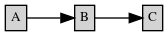

In [21]:
utils.drawGraphHorizontal("A->B;B->C")

### Question 5.1

<div style="float:left;margin:0 10px 10px 0">
    <img src="question.png">
</div>
Dans les 2 cellules suivantes, dessiner les graphes pour 5 variables $A,B,C,D,E$ complètement indépendantes puis pour ces 5 même variables sans aucune indépendance.

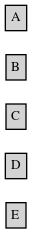

In [22]:
utils.drawGraphHorizontal("E D C B A") # changer la chaîne pour représenter une indépendance complète entre A,B,C,D,E

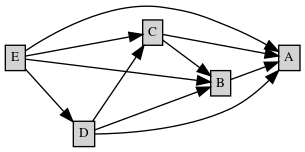

In [23]:
utils.drawGraphHorizontal("E E->D E->C D->C E->B D->B C->B E->A D->A C->A B->A") # changer la chaîne pour représenter une dépendance complète entre A,B,C,D,E-

### Question 5.2 : naïve Bayes

Un modèle simple souvent utilisée est le **Naïve Bayes**. Il suppose que $2$ attributs sont toujours indépendants conditionnellement à `target`.

Ce modèle est évidemment très simpliste et certainement faux. Toutefois, en classification, il donne souvent de bon résultats.

<div style="float:left;margin:0 10px 10px 0">
    <img src="question.png">
</div>
Écrire comment se décompose la vraisemblance $P(attr1,attr2,attr3,\cdots|target)$.

Écrire comment se décompole la distribution a posteriori $P(target|attr1,attr2,attr3,\cdots)$ <em>(ou du moins une fonction proportionnelle à cette distribution a posteriori)</em>.

(votre réponse ici)

$$P(attr1,attr2,attr3,\cdots|target) = P(attr1|target) * P(attr2|target) * P(attr3|target) * \cdots$$

$$P(target|attr1,attr2,attr3,\cdots)= \frac{P(attr1,attr2,attr3,\cdots|target) * P(target)} {P(attr1,attr2,attr3,\cdots)}$$ <br>
$$ = \frac{P(attr1|target) * P(attr2|target) * P(attr3|target) * \cdots * P(target)} {P(attr1,attr2,attr3,\cdots)} $$

### Question 5.3 : modèle graphique et naïve bayes

Un modèle naïve bayes se représente sous la forme d'un graphe où le noeud `target` est l'unique parent de tous les attributs. Construire une fonction `drawNaiveBayes` qui a partir d'un dataframe et du nom de la colonne qui est la classe, dessine le graphe. 

**Note** : une fonction qui dessine un graphe retourne un appel à `utils.drawGraph`, par exemple :

`
def dessin_A_vers_B():
    return utils.drawGraph("A->B")
`

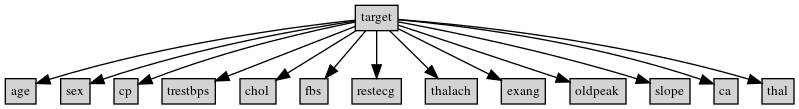

In [24]:
projet.drawNaiveBayes(train,"target")

Écrire une fonction `nbrParamsNaiveBayes` qui calcule la taille mémoire nécessaire pour représenter les tables de probabilité étant donné un dataframe, en supposant qu'un float est représenté sur 8octets et **en utilisant l'hypothèse du Naive Bayes**.

In [25]:
projet.nbParamsNaiveBayes(train,'target',[])
projet.nbParamsNaiveBayes(train,'target',['target','thal'])
projet.nbParamsNaiveBayes(train,'target',['target','age'])
projet.nbParamsNaiveBayes(train,'target',['target','age','thal','sex','exang'])
projet.nbParamsNaiveBayes(train,'target',['target','age','thal','sex','exang','slope','ca','chol'])
projet.nbParamsNaiveBayes(train,'target')

0 variable(s) : 16 octets
2 variable(s) : 80 octets
2 variable(s) : 224 octets
5 variable(s) : 352 octets
8 variable(s) : 736 octets
14 variable(s) : 1584 octets


1584

On voit que l'augmentation de la mémoire nécessaire est raisonnable.

### Question 5.4 : classifier naïve bayes

Afin de ne pas avoir à réécrire la méthode `statsOnDF` qui ne devrait pas changer, écrire les classes `MLNaiveBayesClassifier` et `MAPNaiveBayesClassifier` qui hérite de `AprioriClassifier` et qui utilise le maximum de vraisemblance (ML) et le maximum a posteriori (MAP) pour estimer la classe d'un individu en utilisant l'hypothèse du Naïve Bayes.

De la même façon que plus haut, penser à calculer tous les paramètres du Naïve Bayes dans le constructeur de la classe afin de ne pas les recalculer pour chaque classification.

Décomposer la méthodes `estimClass` en 2 parties : `estimProbas` qui calcule la vraisemblance et `estimClass` qui utilise `estimProbas` pour choisir la classe comme dans les classifieurs précédents.

## Case of missing values in oldpeak

In [26]:
print(sorted(train['oldpeak'].unique()))
print(sorted(test['oldpeak'].unique()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 15]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


In [27]:
cl=projet.MLNaiveBayesClassifier(train)
for i in [0,1,2]:
    print("Estimation de la proba de l'individu {} par MLNaiveBayesClassifier : {}".format(i,cl.estimProbas(utils.getNthDict(train,i))))
    print("Estimation de la classe de l'individu {} par MLNaiveBayesClassifier : {}".format(i,cl.estimClass(utils.getNthDict(train,i)))) 
print("test en apprentissage : {}".format(cl.statsOnDF(train)))
print("test en validation: {}".format(cl.statsOnDF(test)))

Estimation de la proba de l'individu 0 par MLNaiveBayesClassifier : {0: 5.265474022893807e-11, 1: 8.779438846356187e-12}
Estimation de la classe de l'individu 0 par MLNaiveBayesClassifier : 0
Estimation de la proba de l'individu 1 par MLNaiveBayesClassifier : {0: 0.0, 1: 1.9903404816168002e-09}
Estimation de la classe de l'individu 1 par MLNaiveBayesClassifier : 1
Estimation de la proba de l'individu 2 par MLNaiveBayesClassifier : {0: 3.6835223975945704e-10, 1: 1.5920340255297033e-06}
Estimation de la classe de l'individu 2 par MLNaiveBayesClassifier : 1
test en apprentissage : {'VP': 350, 'VN': 116, 'FP': 22, 'FN': 54, 'Précision': 0.9408602150537635, 'Rappel': 0.8663366336633663}
test en validation: {'VP': 49, 'VN': 60, 'FP': 2, 'FN': 89, 'Précision': 0.9607843137254902, 'Rappel': 0.35507246376811596}


In [28]:
cl=projet.MAPNaiveBayesClassifier(train)
for i in [0,1,2]:
    print("Estimation de la proba de l'individu {} par MAPNaiveBayesClassifier : {}".format(i,cl.estimProbas(utils.getNthDict(train,i))))
    print("Estimation de la classe de l'individu {} par MAPNaiveBayesClassifier : {}".format(i,cl.estimClass(utils.getNthDict(train,i)))) 
print("test en apprentissage : {}".format(cl.statsOnDF(train)))
print("test en validation: {}".format(cl.statsOnDF(test)))

Estimation de la proba de l'individu 0 par MAPNaiveBayesClassifier : {0: 0.6719863008964105, 1: 0.32801369910358946}
Estimation de la classe de l'individu 0 par MAPNaiveBayesClassifier : 0
Estimation de la proba de l'individu 1 par MAPNaiveBayesClassifier : {0: 0.0, 1: 1.0}
Estimation de la classe de l'individu 1 par MAPNaiveBayesClassifier : 1
Estimation de la proba de l'individu 2 par MAPNaiveBayesClassifier : {0: 7.90267948988375e-05, 1: 0.9999209732051012}
Estimation de la classe de l'individu 2 par MAPNaiveBayesClassifier : 1
test en apprentissage : {'VP': 382, 'VN': 111, 'FP': 27, 'FN': 22, 'Précision': 0.9339853300733496, 'Rappel': 0.9455445544554455}
test en validation: {'VP': 53, 'VN': 57, 'FP': 5, 'FN': 85, 'Précision': 0.9137931034482759, 'Rappel': 0.38405797101449274}


## Question 6 : <em>feature selection</em> dans le cadre du classifier naive bayes

Il est possible qu'un attribut de la base ne soit pas important pour estimer la classe d'un individu. Dans le cadre du Naïve Bayes, un tel noeud se reconnaît car il est indépendant de `target`. Un tel noeud peut être supprimé du Naïve Bayes.

Écrire une fonction `isIndepFromTarget(df,attr,x)` qui vérifie si `attr` est indépendant de `target` au seuil de x%.

*Note* : vous avez le droit d'utiliser `scipy.stats.chi2_contingency` dans cette fonction.

In [29]:
for attr in train.keys():
    if attr!='target':
        print("target independant de {} ? {}".format(attr,"**YES**" if projet.isIndepFromTarget(train,attr,0.01) else "no"))

target independant de age ? no
target independant de sex ? no
target independant de cp ? no
target independant de trestbps ? **YES**
target independant de chol ? no
target independant de fbs ? **YES**
target independant de restecg ? no
target independant de thalach ? no
target independant de exang ? no
target independant de oldpeak ? no
target independant de slope ? no
target independant de ca ? no
target independant de thal ? no


Proposer des classifieurs `ReducedMLNaiveBayesClassifier` et `ReducedMAPNaiveBayesClassifier` qui utilisent le maximum de vraisemblance (ML) et le maximum a posteriori (MAP) pour estimer la classe d'un individu sur un modèle Naïve Bayes qu'ils auront préalablement optimisé grâce à des tests d'indépendance au seuil de $x\%$ (donné en paramètre du constructeur). Rajouter une méthode `ReducedMAPNaiveBayesClassifier.draw` afin de pouvoir dessiner le Naïve Bayes réduit effectivement utilisé. 

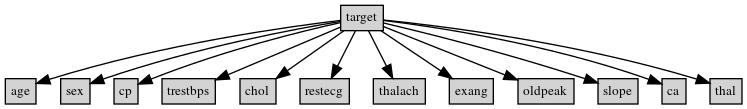

In [30]:
cl=projet.ReducedMLNaiveBayesClassifier(train,0.05)
cl.draw()

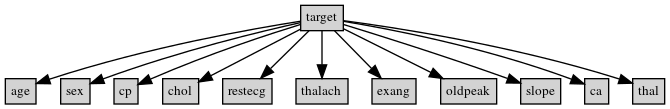

In [31]:
cl=projet.ReducedMLNaiveBayesClassifier(train,0.01)
cl.draw()

In [32]:
for i in [0,1,2]:
    print("Estimation de la proba de l'individu {} par MAPNaiveBayesClassifier : {}".format(i,cl.estimProbas(utils.getNthDict(train,i))))
    print("Estimation de la classe de l'individu {} par MAPNaiveBayesClassifier : {}".format(i,cl.estimClass(utils.getNthDict(train,i)))) 
print("test en apprentissage : {}".format(cl.statsOnDF(train)))
print("test en validation: {}".format(cl.statsOnDF(test)))

Estimation de la proba de l'individu 0 par MAPNaiveBayesClassifier : {0: 5.697482232499412e-09, 1: 2.138723717532643e-09}
Estimation de la classe de l'individu 0 par MAPNaiveBayesClassifier : 0
Estimation de la proba de l'individu 1 par MAPNaiveBayesClassifier : {0: 0.0, 1: 1.1475745797921708e-08}
Estimation de la classe de l'individu 1 par MAPNaiveBayesClassifier : 1
Estimation de la proba de l'individu 2 par MAPNaiveBayesClassifier : {0: 2.7487852876093664e-09, 1: 9.179222322695213e-06}
Estimation de la classe de l'individu 2 par MAPNaiveBayesClassifier : 1
test en apprentissage : {'VP': 348, 'VN': 117, 'FP': 21, 'FN': 56, 'Précision': 0.943089430894309, 'Rappel': 0.8613861386138614}
test en validation: {'VP': 49, 'VN': 61, 'FP': 1, 'FN': 89, 'Précision': 0.98, 'Rappel': 0.35507246376811596}


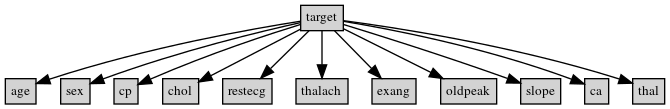

In [33]:
cl=projet.ReducedMAPNaiveBayesClassifier(train,0.01)
cl.draw()

In [34]:
for i in [0,1,2]:
    print("Estimation de la proba de l'individu {} par MAPNaiveBayesClassifier : {}".format(i,cl.estimProbas(utils.getNthDict(train,i))))
    print("Estimation de la classe de l'individu {} par MAPNaiveBayesClassifier : {}".format(i,cl.estimClass(utils.getNthDict(train,i)))) 
print("test en apprentissage : {}".format(cl.statsOnDF(train)))
print("test en validation: {}".format(cl.statsOnDF(test)))

Estimation de la proba de l'individu 0 par MAPNaiveBayesClassifier : {0: 0.47643095845795086, 1: 0.5235690415420491}
Estimation de la classe de l'individu 0 par MAPNaiveBayesClassifier : 1
Estimation de la proba de l'individu 1 par MAPNaiveBayesClassifier : {0: 0.0, 1: 1.0}
Estimation de la classe de l'individu 1 par MAPNaiveBayesClassifier : 1
Estimation de la proba de l'individu 2 par MAPNaiveBayesClassifier : {0: 0.00010227941341238206, 1: 0.9998977205865877}
Estimation de la classe de l'individu 2 par MAPNaiveBayesClassifier : 1
test en apprentissage : {'VP': 375, 'VN': 110, 'FP': 28, 'FN': 29, 'Précision': 0.9305210918114144, 'Rappel': 0.9282178217821783}
test en validation: {'VP': 53, 'VN': 56, 'FP': 6, 'FN': 85, 'Précision': 0.8983050847457628, 'Rappel': 0.38405797101449274}


## Question 7 : évaluation des classifieurs

Nous commençons à avoir pas mal de classifieurs. Pour les comparer, une possibilité est d'utiliser la représentation graphique des points $(précision,rappel)$ de chacun.

### Question 7.1

<div style="float:left;margin:0 10px 10px 0">
    <img src="question.png">
</div>
Où se trouve à votre avis le point idéal ? Comment pourriez-vous proposer de comparer les différents classifieurs dans cette représentation graphique ?

Le point idéal est le point qui correspont à une précision et un rappel = 100 % qui est (1, 1) ou (100%, 100%). <br>

On peut comparer les différents classifieurs en calculant leurs distance euclidienne avec (1, 1), le plus proche sera le mieux. <br>

Dans la realité, il vaut mieux de construire notre maniere pour calculer l'efficacité d'un classifieurs avec en multipliant les 2 métriques par des poids différents ( par exemple, le cas du CIA ) 
<img src="CIA_error.png"><center>source: https://youtu.be/L_0efNkdGMc?t=1862<center>

### Question 7.2 

Ecrire une fonction `mapClassifiers(dic,df)` qui, à partir d'un dictionnaire `dic` de `{nom:instance de classifier}` et d'un dataframe `df`, représente graphiquement ces classifiers dans l'espace $(précision,rappel)$.

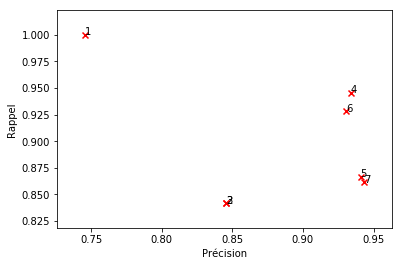

In [35]:
projet.mapClassifiers({"1":projet.APrioriClassifier(),
                "2":projet.ML2DClassifier(train,"exang"),
                "3":projet.MAP2DClassifier(train,"exang"),
                "4":projet.MAPNaiveBayesClassifier(train),
                "5":projet.MLNaiveBayesClassifier(train),
                "6":projet.ReducedMAPNaiveBayesClassifier(train,0.01),
                "7":projet.ReducedMLNaiveBayesClassifier(train,0.01),
               },train)

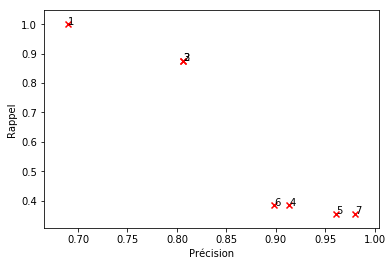

In [36]:
projet.mapClassifiers({"1":projet.APrioriClassifier(),
                "2":projet.ML2DClassifier(train,"exang"),
                "3":projet.MAP2DClassifier(train,"exang"),
                "4":projet.MAPNaiveBayesClassifier(train),
                "5":projet.MLNaiveBayesClassifier(train),
                "6":projet.ReducedMAPNaiveBayesClassifier(train,0.01),
                "7":projet.ReducedMLNaiveBayesClassifier(train,0.01),
               },test)

## Question 8 : Sophistication du modèle (question BONUS)

Utiliser un arbre pour représenter la factorisation de la loi jointe est bien sûr une simplification : beaucoup de distribution ne peuvent être représentées avec un seul parent par variable.

Un modèle plus sophisitiqué existe donc : le TAN (Tree-augmented Naïve Bayes). Il consiste à rajouter au plus un parent à chaque attribut parmi les autres attributs (sans créer de cycle). En plus des arcs les reliant à la classe, un TABN induit donc un arbre (plus exactement une forêt) parmi les attributs.

Ci-dessous un TAN dont la classe est $T$.

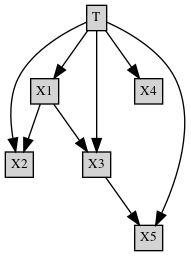

In [37]:
utils.drawGraph("T->X1;T->X2;T->X3;T->X4;T->X5;X1->X2;X1->X3;X3->X5")

et dont l'arbre (la forêt) sur les attributs est bien :

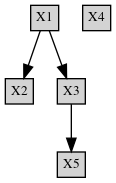

In [38]:
utils.drawGraph("X1->X2;X1->X3;X3->X5;X4")

L'algorithme pour générer cette structure se base sur une autre façon de tester l'indépendance entre deux variables aléatoires : l'information mutuelle qui calcule une distance entre la distribution des 2 variables et la distribution si ces 2 variables étaient indépendantes (voir https://fr.wikipedia.org/wiki/Information_mutuelle). Pour construire l'arbre (la forêt) entre les attributs, sachant qu'on garde les arcs issus de la classe, il faut tester des indépendances conditionnelles et donc calculer des informations mutuelles conditionnelles (https://en.wikipedia.org/wiki/Conditional_mutual_information).

On gardera de ces pages les deux formules :
$$I(X;Y)=\sum_{x,y} P(x,y)\log_2\frac{P(x,y)}{P(x)P(y)}$$

$$I(X;Y|Z)=\sum_{z,x,y} P(x,y,z)\log_2\frac{P(z)P(x,y,z)}{P(x,z)P(y,z)}$$

Et on remarquera que :
- $P(x,z)=\sum_y P(x,y,z)$, 
- $P(y,z)=\sum_x P(x,y,z)$, 
- $P(z)=\sum_{x,y} P(x,y,z)$, 
- etc.

## Question 8.1 : calcul des informations mutuelles
Écrire des fonctions `projet.MutualInformation(df,x,y)` et `projet.ConditionalMutualInformation(df,x,y,z)` qui calcule ces informations mutuelles

In [39]:
for attr in train.keys():
    if attr!='target':
        print("{}->{} : {}".format("target",attr,projet.MutualInformation(train,"target",attr)))

AttributeError: module 'projet' has no attribute 'MutualInformation'

(On retrouve au passage que trestbs et surtout fbs sont très peu dépendantes de la classe ...)

In [ ]:
cmis=np.array([[0 if x==y else projet.ConditionalMutualInformation(train,x,y,"target") 
                for x in train.keys() if x!="target"]
               for y in train.keys() if y!="target"])
cmis[0:5,0:5]

(on remarque que, évidemment, la matrice `cmis` est symétrique)

## Question 8.2 : calcul de la matrice des poids
La matrice `cmis` calculé ci-dessus représente l'ensemble des arcs possibles entre les attributs et leur poids. Pour trouver un arbre dans ces arcs, on commence par simplifier cette matrice en supprimant les poids faibles. Par exemple, en retirant la moyenne.

Faites une fonction `projet.MeanForSymetricWeights(a)` qui calcule la moyenne des poids pour une matrice `a` symétrique de diagonale nulle.

Puis écrire une fonction `projet.simplifyContitionalMutualInformationMatrix(a)` qui annule toutes les valeurs plus petites que cette moyenne dans une matrice  `a` symétrique de diagonale nulle.

In [ ]:
projet.MeanForSymetricWeights(cmis)

In [ ]:
projet.SimplifyConditionalMutualInformationMatrix(cmis)
cmis[0:5,0:5]

## Question 8.3 : Arbre (forêt) optimal entre les attributs

Un algorithme pour trouver un arbre de poids maximal est l'algorithm de Kruskal (https://fr.wikipedia.org/wiki/Algorithme_de_Kruskal). En se souvenant qu'on veut relier les attributs si ils sont très dépendants, écrire la fonction `projet.Kruskal(df,a)` qui propose la liste des arcs (non orientés pour l'instant) à ajouter dans notre classifieur sous la forme d'une liste de triplet $(attr1,attr2,poids)$. 

<b>Remarque</b> : `df` ne sert ici qu'à retrouver le nom des attributs à partir de leur indice grâce à `train.keys()[i]`.

In [ ]:
liste_arcs=projet.Kruskal(train,cmis)
liste_arcs

## Question 8.4: Orientation des arcs entre attributs.

Il s'agit maintenant d'orienter l'arbre (la forêt) entre les attributs. On choisit la (ou les) racine(s) en maximisant l'information mutuelle entre ces attributs et la classe (donc en utilisant `projet.MutualInformation`.

Créer une fonction `projet.ConnexSet(list_arcs)` qui rend une liste d'ensemble d'attributs connectés, 

In [ ]:
# 3 arcs de poids 1 dans le graphe a--b--c   d--e
projet.ConnexSets([('a','b',1),
                   ('a','c',1),
                   ('d','e',1)])

In [ ]:
projet.ConnexSets(liste_arcs)

Puis écrire une fonction `projet.OrientConnexSets(df,arcs,classe)` qui utilise l'information mutuelle (entre chaque attribut et la `classe`) pour proposer pour chaque ensemble d'attributs connexes une racine et qui rend la liste des arcs orientés.

In [ ]:
projet.OrientConnexSets(train,liste_arcs,'target')

## Question 8.5: Classifieur TAN
Écrire un `MAPTANClassifier(df)` qui construit un modèle TAN en suivant la procédure ci-dessus. Lui ajouter une procédure `Draw()`

In [ ]:
tan=projet.MAPTANClassifier(train)
tan.draw()

In [ ]:
for i in [0,1,2]:
    print("Estimation de la proba de l'individu {} par MAPTANClassifier : {}".format(i,tan.estimProbas(utils.getNthDict(train,i))))
    print("Estimation de la classe de l'individu {} par MAPTANClassifier : {}".format(i,tan.estimClass(utils.getNthDict(train,i)))) 
print("test en apprentissage : {}".format(tan.statsOnDF(train)))
print("test en validation: {}".format(tan.statsOnDF(test)))

In [ ]:
projet.mapClassifiers({"1":projet.APrioriClassifier(),
                "2":projet.ML2DClassifier(train,"exang"),
                "3":projet.MAP2DClassifier(train,"exang"),
                "4":projet.MAPNaiveBayesClassifier(train),
                "5":projet.MLNaiveBayesClassifier(train),
                "6":projet.ReducedMAPNaiveBayesClassifier(train,0.01),
                "7":projet.ReducedMLNaiveBayesClassifier(train,0.01),
                "8":projet.MAPTANClassifier(train),
               },train)

In [ ]:
projet.mapClassifiers({"1":projet.APrioriClassifier(),
                "2":projet.ML2DClassifier(train,"exang"),
                "3":projet.MAP2DClassifier(train,"exang"),
                "4":projet.MAPNaiveBayesClassifier(train),
                "5":projet.MLNaiveBayesClassifier(train),
                "6":projet.ReducedMAPNaiveBayesClassifier(train,0.01),
                "7":projet.ReducedMLNaiveBayesClassifier(train,0.01),
                "8":projet.MAPTANClassifier(train),
               },test)

### Question 9

<div style="float:left;margin:0 10px 10px 0">
    <img src="question.png">
</div>
Quelle leçons & conclusion tirez-vous de ces expériences sur les classifieurs bayésiens ?

(ici votre réponse)